In [3]:
%matplotlib notebook
import os
import os.path as path
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt



from pyccapt.calibration_tools import variables, tools, data_tools
from pyccapt.mc import mc_tools

# The initial value for flight path length, which is the distance of local electrod to detector 
flightPathLength = 110 # mm
# The initial value for t_0
t0 = 1 # ns

# if you want to save the picture the process takes too long
# For faster run put save_figure to False
save_figure = False

In [6]:
variables.init()

# dataset name
# dataset_name = 'AL_data_b'
dataset_name = 'OLO_AL_6_data'
# dataset_name = 'OLO_W_6_data'
# dataset_name = 'OLO_Ni_8_data'
# dataset_name = 'X6Cr17_2V30Min_5_data'
# dataset_name = 'OLO_AL_6_data'

p = path.abspath(path.join("", "../../../../.."))

variables.path = os.path.join(p, 'tests//results//load_crop')
variables.result_path = os.path.join(p, 'tests/results/tof_calibration/' + dataset_name)
if not os.path.isdir(variables.result_path):
        os.makedirs(variables.result_path, mode=0o777, exist_ok=True)

filename = variables.path + '//' + dataset_name + '//' + dataset_name + '_cropped' + '.h5'

head, tail = os.path.split(filename)
figname = os.path.splitext(tail)[0]

data = data_tools.read_hdf5_through_pandas(filename)


dld_highVoltage = data['dld/high_voltage'].to_numpy()
dld_pulseVoltage = data['dld/pulse_voltage'].to_numpy()
dld_startCounter = data['dld/start_counter'].to_numpy()
dld_t = data['dld/t'].to_numpy()
dld_x = data['dld/x'].to_numpy()
dld_y = data['dld/y'].to_numpy()

In [7]:
data

,dld/high_voltage,dld/pulse_voltage,dld/start_counter,dld/t,dld/x,dld/y
0,5213.360352,5213.360352,38396.0,630.414792,17.828571,-14.262857
1,5213.360352,5213.360352,38698.0,650.296134,27.093061,19.770612
2,5213.360352,5213.360352,39073.0,647.792964,26.679184,20.248163
3,5213.360352,5213.360352,39830.0,627.609870,8.086531,-10.124082
4,5213.360352,5213.360352,40475.0,3565.145016,-28.334694,-4.075102
...,...,...,...,...,...,...
1900693,5710.761719,5710.761719,39864.0,603.901764,-11.811429,-3.533878
1900694,5710.761719,5710.761719,40013.0,604.951038,-12.989388,-2.451429
1900695,5710.761719,5710.761719,40267.0,619.167672,29.894694,10.442449
1900696,5710.761719,5710.761719,40371.0,605.712276,-12.798367,-0.986939


$\mathbf{\text{calculate the mc in two mode:}}$<br>
$$\frac{m}{n} = k V_{dc}(\frac{t + t_{0}}{d})^{2} $$<br>

$$\frac{m}{n} = k\alpha (V_{dc} + \beta V_{pulse})(\frac{t + t_{0}}{d})^{2} $$<br>

<IPython.core.display.Javascript object>


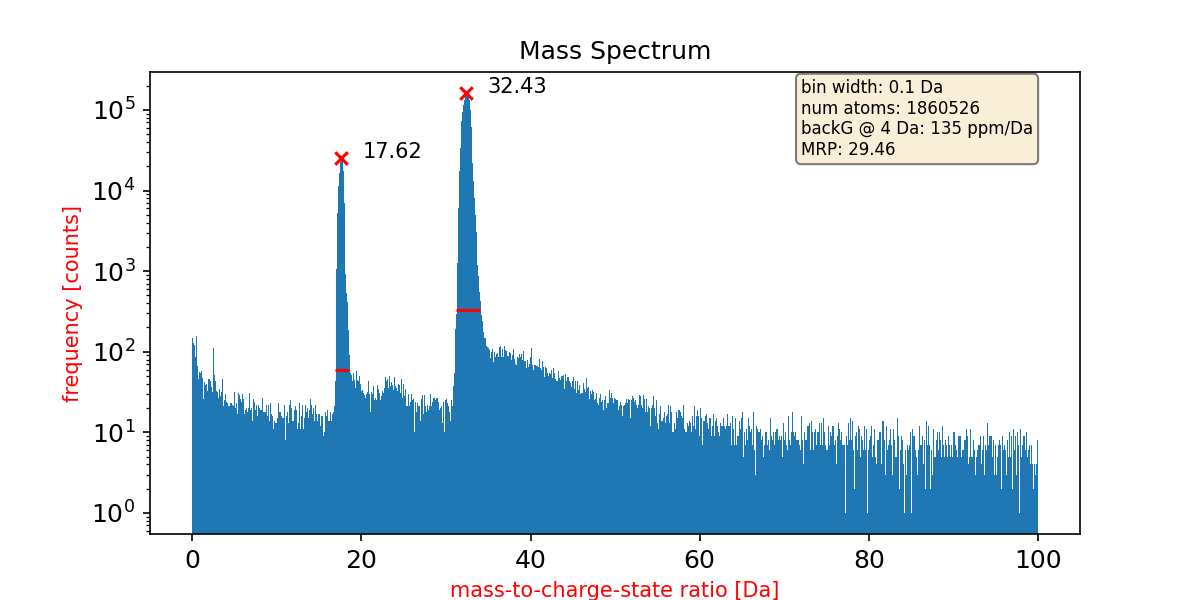

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [29.46039952]
Peaks  0 is: 17.62 peak window sides are: 17.22 - 17.92
Peaks  1 is: 32.43 peak window sides are: 31.83 - 32.93


In [8]:
mc_seb = mc_tools.tof2mc(dld_t, t0, dld_highVoltage, dld_pulseVoltage, dld_x, dld_y, flightPathLength, mode='voltage_pulse')
max_hist_ini, left_right_peaks_ini, peaks_sides_ini, max_paek_edges_ini, index_max_ini = tools.massSpecPlot(mc_seb[mc_seb < 100], 0.1, percent=50, plot=True, prominence=500, fig_name=figname)
mrp = (max_hist_ini / (left_right_peaks_ini[1] - left_right_peaks_ini[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_ini)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_ini[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_ini[i,2], peaks_sides_ini[i,3]))

<IPython.core.display.Javascript object>


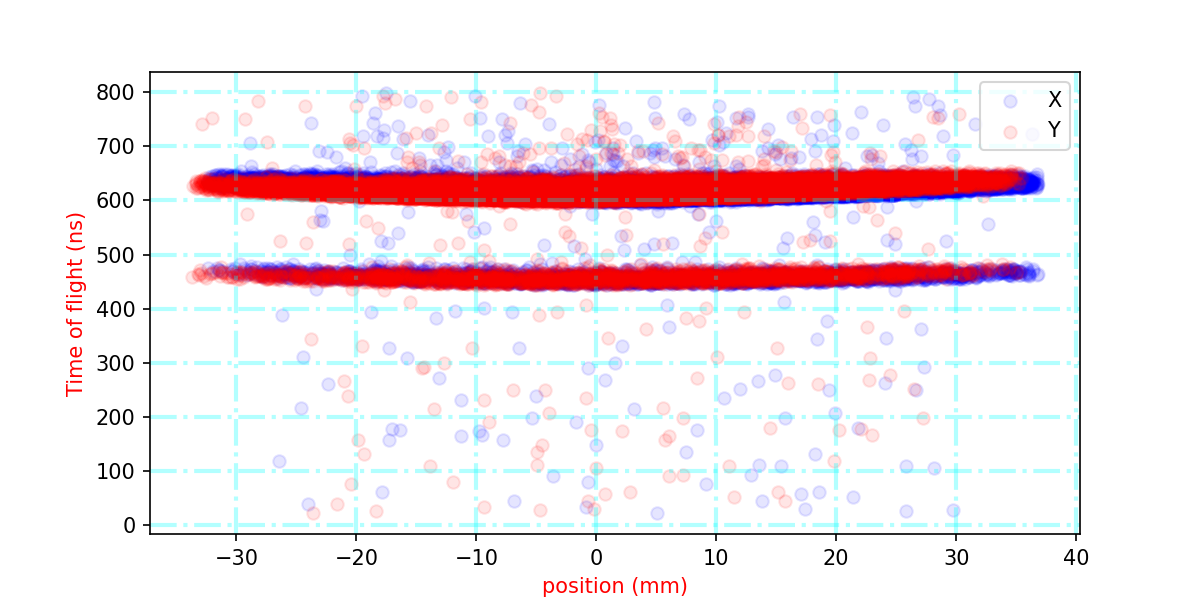

In [9]:
# use mask_equal to have equal number of ions for each peak
# only peak the value in the center of detector 4mm * 4mm
random_sample = np.random.choice(np.arange(len(dld_t)), size=30000, replace=False)

dld_t_plot = dld_t[random_sample]
dld_x_plot = dld_x[random_sample]
dld_y_plot = dld_y[random_sample]
fig1, ax1 = plt.subplots(figsize=(8, 4))
x = plt.scatter(dld_x_plot[dld_t_plot<800], dld_t_plot[dld_t_plot<800], color="blue", label='X', alpha=0.1)
y = plt.scatter(dld_y_plot[dld_t_plot<800], dld_t_plot[dld_t_plot<800], color="red", label='Y', alpha=0.1)
ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=10)
ax1.set_xlabel("position (mm)", color="red", fontsize=10)
plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)
plt.legend(handles=[x, y], loc='upper right')
if save_figure == True:
    plt.savefig(variables.result_path + '/center_' + "%s.png" %figname, format="png", dpi=600)
plt.show()

In [ ]:
# Create a list of all ions in the peaks
pick_ions_plot = []

# creat mask for each peak base on the peak loc. and window size
for i in range(len(peaks_sides_ini)):
    mask_tmp = np.logical_and((peaks_sides_ini[i, 2] < mc_seb), (mc_seb < peaks_sides_ini[i, 3]))
    print('The number of ions in peak %s are:' %i, len(mask_tmp[mask_tmp==True]))
    pick_ions_plot.append(mask_tmp)

In [ ]:
# use mask_equal to have equal number of ions for each peak
# only peak the value in the center of detector 4mm * 4mm
detector_squre = 2


mask_tmp_middle = np.logical_and((np.abs(dld_x) < detector_squre), (np.abs(dld_y) < detector_squre))
print('Total # inons in 4mm * 4mm:', len(mask_tmp_middle[mask_tmp_middle==True]))
dld_x_masked_mid = dld_x[mask_tmp_middle]
dld_y_masked_mid = dld_y[mask_tmp_middle]
dld_t_masked_mid = dld_t[mask_tmp_middle]
dld_highVoltage_masked_mid = dld_highVoltage[mask_tmp_middle]
dld_pulseVoltage_masked_mid = dld_pulseVoltage[mask_tmp_middle]



In [ ]:
# use mask_equal to have equal number of ions for each peak
# only peak the value in the center of detector 4mm * 4mm

random_sample = np.random.choice(np.arange(len(dld_t_masked_mid)), size=10000, replace=False)

dld_t_masked_mid_plot = dld_t_masked_mid[random_sample]
dld_x_masked_mid_plot = dld_x_masked_mid[random_sample]
dld_y_masked_mid_plot = dld_y_masked_mid[random_sample]


fig1, ax1 = plt.subplots(figsize=(8, 4))
x = plt.scatter(dld_x_masked_mid_plot[dld_t_masked_mid_plot<800], dld_t_masked_mid_plot[dld_t_masked_mid_plot<800], color="blue", label='X', alpha=0.1)
y = plt.scatter(dld_y_masked_mid_plot[dld_t_masked_mid_plot<800], dld_t_masked_mid_plot[dld_t_masked_mid_plot<800], color="red", label='Y', alpha=0.1)
ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=10)
ax1.set_xlabel("position (mm)", color="red", fontsize=10)
plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)
plt.legend(handles=[x, y], loc='upper right')
if save_figure == True:
    plt.savefig(variables.result_path + '/center_' + "%s.png" %figname, format="png", dpi=1200)
plt.show()

In [ ]:
mc_seb_mid = mc_tools.tof2mc(dld_t_masked_mid, t0, dld_highVoltage_masked_mid, dld_pulseVoltage_masked_mid, dld_x_masked_mid, dld_y_masked_mid, flightPathLength, mode='voltage_pulse')
max_hist, left_right_peaks, peaks_sides, max_paek_edges, index_max = tools.massSpecPlot(mc_seb_mid[mc_seb_mid < 100], 0.1, percent=50, plot=True, prominence=50, distance=50, fig_name=figname)
mrp = (max_hist / (left_right_peaks[1] - left_right_peaks[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides[i,2], peaks_sides[i,3]))

In [ ]:
peak_ideal = [1.01, 13.49, 26.98]  

# creat mask for each peak base on the peak loc. and window size
for i in range(len(peaks_sides_ini)):
    mask_tmp = np.logical_and((peaks_sides_ini[i, 2] < mc_seb_mid), (mc_seb_mid < peaks_sides_ini[i, 3]))
    print('Number of Ions in peak %s and 4mm*4mm:' %i,len(np.where(mask_tmp==True)[0].tolist()  ))
    if i == 0:
        lenght = len(mask_tmp[mask_tmp==True])
        indexes_mask_tmp_equal = np.where(mask_tmp==True)[0].tolist()
    else:    

        indexes_mask_tmp_equal = np.where(mask_tmp==True)[0].tolist()    
        indexes_mask_tmp_equal = np.random.choice(indexes_mask_tmp_equal, size=lenght, replace=False)
    
    
    bb = np.zeros(len(mc_seb_mid))
    
    mc_seb_ideal_tmp = np.copy(bb)
    # put the location (mc) of the peak for all selected mc
    mc_seb_ideal_tmp[mask_tmp] = peak_ideal[i]
    
    if i == 0:
        mask = np.copy(mask_tmp)
        mc_seb_ideal = np.copy(mc_seb_ideal_tmp)
        mask_equal = indexes_mask_tmp_equal
    else:
        mask += mask_tmp
        mc_seb_ideal += mc_seb_ideal_tmp 
        mask_equal.extend(indexes_mask_tmp_equal)

In [ ]:
mc_seb_masked = mc_seb_mid[mask]
tools.massSpecPlot(mc_seb_masked[mc_seb_masked < 100], 0.1, peaks_find=False, plot=True)

In [ ]:
tools.massSpecPlot(mc_seb_ideal, 0.1, peaks_find=False, plot=True)

In [ ]:
for i in range(len(pick_ions_plot)):
    fig1, ax1 = plt.subplots(figsize=(8, 4))
    
    dld_x_masked = dld_x[pick_ions_plot[i]]
    dld_y_masked = dld_y[pick_ions_plot[i]]
    dld_t_masked = dld_t[pick_ions_plot[i]]
    x = plt.scatter(dld_x_masked, dld_t_masked, color="blue", label='X', alpha=0.1)
    y = plt.scatter(dld_y_masked, dld_t_masked, color="red", label='Y', alpha=0.1)
    ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=10)
    ax1.set_xlabel("position (mm)", color="red", fontsize=10)
    plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)
    plt.legend(handles=[x, y], loc='upper right')
    if save_figure == True:
        plt.savefig(variables.result_path + '/position_peak_%s' %i + "%s.png" %figname, format="png", dpi=600)
    plt.show()

$$\frac{m}{n} = k\alpha (V_{dc} + \beta V_{pulse})(\frac{t + t_{0}}{d})^{2} $$<br>
$\mathbf{\text{Reformulate the equation:}}$<br>
$$t = d(\sqrt{\frac{\frac{m}{n}}{k\alpha (V_{dc}+\beta V_{pulse})}})-t_{0} $$<br>

In [ ]:
# use mask_equal to have equal number of ions for each peak
# only peak the value in the center of detector 4mm * 4mm

fig1, ax1 = plt.subplots(figsize=(8, 4))
dld_x_masked = dld_x_masked_mid[mask_equal]
dld_y_masked = dld_y_masked_mid[mask_equal]
dld_t_masked = dld_t_masked_mid[mask_equal]


x = plt.scatter(dld_x_masked, dld_t_masked, color="blue", label='X', alpha=0.1)
y = plt.scatter(dld_y_masked, dld_t_masked, color="red", label='Y', alpha=0.1)
ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=10)
ax1.set_xlabel("position (mm)", color="red", fontsize=10)
plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)
plt.legend(handles=[x, y], loc='upper right')
if save_figure == True:
    plt.savefig(variables.result_path + '/center_' + "%s.png" %figname, format="png", dpi=600)
plt.show()


In [ ]:
# use mask_equal to have equal number of ions for each peak
dld_x_masked = dld_x_masked_mid[mask_equal]
dld_y_masked = dld_y_masked_mid[mask_equal]
dld_t_masked = dld_t_masked_mid[mask_equal]

dld_highVoltage_masked = dld_highVoltage_masked_mid[mask_equal]
dld_pulseVoltage_masked = dld_pulseVoltage_masked_mid[mask_equal]


mc_seb_reg_masked = mc_seb_ideal[mask_equal]


seb_t = dld_t_masked * 1E-9  # tof in s
# seb_factor = np.sqrt(mc_seb_reg_ideal[mask_middle] * 1.66E-27 / (2 * 1.6E-19 * 1.015 * (dld_highVoltage_masked + 0.7 * dld_pulseVoltage_masked)))
seb_factor = np.sqrt(mc_seb_reg_masked * 1.66E-27 / (2 * 1.6E-19 * dld_highVoltage_masked))

seb_factor = seb_factor * 1E6
seb_t = seb_t * 1E9

In [ ]:

huber = linear_model.HuberRegressor(alpha=1E-9,epsilon=1)
huber.fit(np.array([seb_factor]).squeeze(0).reshape(-1, 1), np.array([seb_t]).squeeze(0))
d_seb_huber = huber.coef_.item()
t0_seb_huber = huber.intercept_.item()          
print('Huber -- 2 the corrected flight path lenght(slop): {:.2f}'.format(d_seb_huber), '(mm)', '\nthe corrected t_0(intercept): {:.2f}'.format(t0_seb_huber), '(ns)')

bayesian_ridge = linear_model.Ridge(alpha=1)
bayesian_ridge.fit(np.array([seb_factor]).squeeze(0).reshape(-1, 1) , np.array([seb_t]).squeeze(0))
d_seb_rigid = bayesian_ridge.coef_.item()
t0_seb_rigid = bayesian_ridge.intercept_.item()         
print('Rigid -- the corrected flight path lenght(slop): {:.2f}'.format(d_seb_rigid), '(mm)', '\nthe corrected t_0(intercept): {:.2f}'.format(t0_seb_rigid), '(ns)')
# Train the model using the data sets ( linear regression)
linear = linear_model.LinearRegression()
linear.fit(np.array([seb_factor]).squeeze(0).reshape(-1, 1), np.array([seb_t]).squeeze(0))
d_seb = linear.coef_.item()
t0_seb = linear.intercept_.item()

print('Linear -- the corrected flight path lenght(slop): {:.2f}'.format(d_seb), '(mm)', '\nthe corrected t_0(intercept): {:.2f}'.format(t0_seb), '(ns)')
# Train the model using the data sets ( Lasso regression)
lasso = linear_model.Lasso(alpha=1)
lasso.fit(np.array([seb_factor]).squeeze(0).reshape(-1, 1), np.array([seb_t]).squeeze(0))
d_seb_lasso = lasso.coef_.item()
t0_seb_lasso = lasso.intercept_.item() 
print('Lasso -- the corrected flight path lenght(slop): {:.2f}'.format(d_seb_lasso), '(mm)', '\nthe corrected t_0(intercept): {:.2f}'.format(t0_seb_lasso), '(ns)')


In [ ]:
# Plot outputs
fig1, ax1 = plt.subplots(figsize=(8, 6))
peaks_data = plt.scatter(seb_factor, seb_t, color="black", label='peaks Ions', alpha=0.1)
axes = plt.gca()
x_vals = np.array(axes.get_xlim())


linear, = plt.plot(x_vals, t0_seb + d_seb * x_vals, '--', color='r', label='Linear' )
rigid, = plt.plot(x_vals, t0_seb_rigid + d_seb_rigid * x_vals, '--', color='b', label='Rigid' )
huber, = plt.plot(x_vals, t0_seb_huber + d_seb_huber * x_vals, '--', color='g', label='Huber' )
lasso, = plt.plot(x_vals, t0_seb_lasso + d_seb_lasso * x_vals, '--', color='y', label='lasso' )

plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)

plt.legend(handles=[peaks_data, linear, rigid, huber,lasso], loc='lower right')
ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=20)
ax1.set_xlabel("sqrt(m/n / (k*alpha*(V_dc+beta*V_pulse)) (ns/mm)", color="red", fontsize=20)

if save_figure == True:
    plt.savefig(variables.result_path + '/regression' + "%s.png" %figname, format="png", dpi=600)

plt.show()

In [ ]:
# update flight path lenght
flightPathLength_new = float("{:.2f}".format(d_seb))
# update t_0
t0_new = float("{:.2f}".format(t0_seb))
print(flightPathLength_new, t0_new)

In [ ]:
# calculate the mc with new flight path lenght and t_0
mc_seb = mc_tools.tof2mc(dld_t, t0_new, dld_highVoltage, dld_pulseVoltage, dld_x, dld_y, flightPathLength_new)

max_hist, left_right_peaks, peaks_sides, max_paek_edges, index_max = tools.massSpecPlot(mc_seb[mc_seb < 100], 0.1, percent=50, plot=True, prominence=500, distance=None, fig_name='corrected_'+figname)
mrp = (max_hist / (left_right_peaks[1] - left_right_peaks[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides[i,2], peaks_sides[i,3]))